# 환경 설정 및 데이터 로딩
이 노트북은 프로젝트 데이터셋과 학습된 파이프라인 정보를 로딩해 이후 분석을 위한 기반 환경을 구성합니다. 필요 라이브러리 버전을 확인하고, 학습 타깃 인코딩을 재현하여 일관된 분석을 보장합니다.

In [1]:
from __future__ import annotations

import json
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

DATA_PATH = Path('..') / 'data' / 'raw' / 'dataset.csv'
MODEL_PATH = Path('..') / 'model' / 'model_trained.pkl'

if not DATA_PATH.exists():
    raise FileNotFoundError(f'Dataset not found at {DATA_PATH.resolve()}')
if not MODEL_PATH.exists():
    raise FileNotFoundError(f'Model artifact not found at {MODEL_PATH.resolve()}')

print('Dataset path:', DATA_PATH.resolve())
print('Model path  :', MODEL_PATH.resolve())

raw_df = pd.read_csv(DATA_PATH)
print('Raw shape   :', raw_df.shape)

pipeline = joblib.load(MODEL_PATH)
feature_names_in_ = list(getattr(pipeline, 'feature_names_in_', []))
print('Pipeline expects', len(feature_names_in_), 'features')

raw_df.head()

Dataset path: C:\LDG\python\python_src\second_prj\data\raw\dataset.csv
Model path  : C:\LDG\python\python_src\second_prj\model\model_trained.pkl
Raw shape   : (4424, 35)
Pipeline expects 28 features
Pipeline expects 28 features


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# 피처 상관계수 분석
수치형 피처들에 대해 타깃과의 피어슨 상관계수를 계산하고 히트맵으로 시각화합니다. 상관분석은 미미한 영향 피처를 선별하는 기초 지표로 활용됩니다.

Numeric columns: 35
Correlation matrix shape: (35, 35)


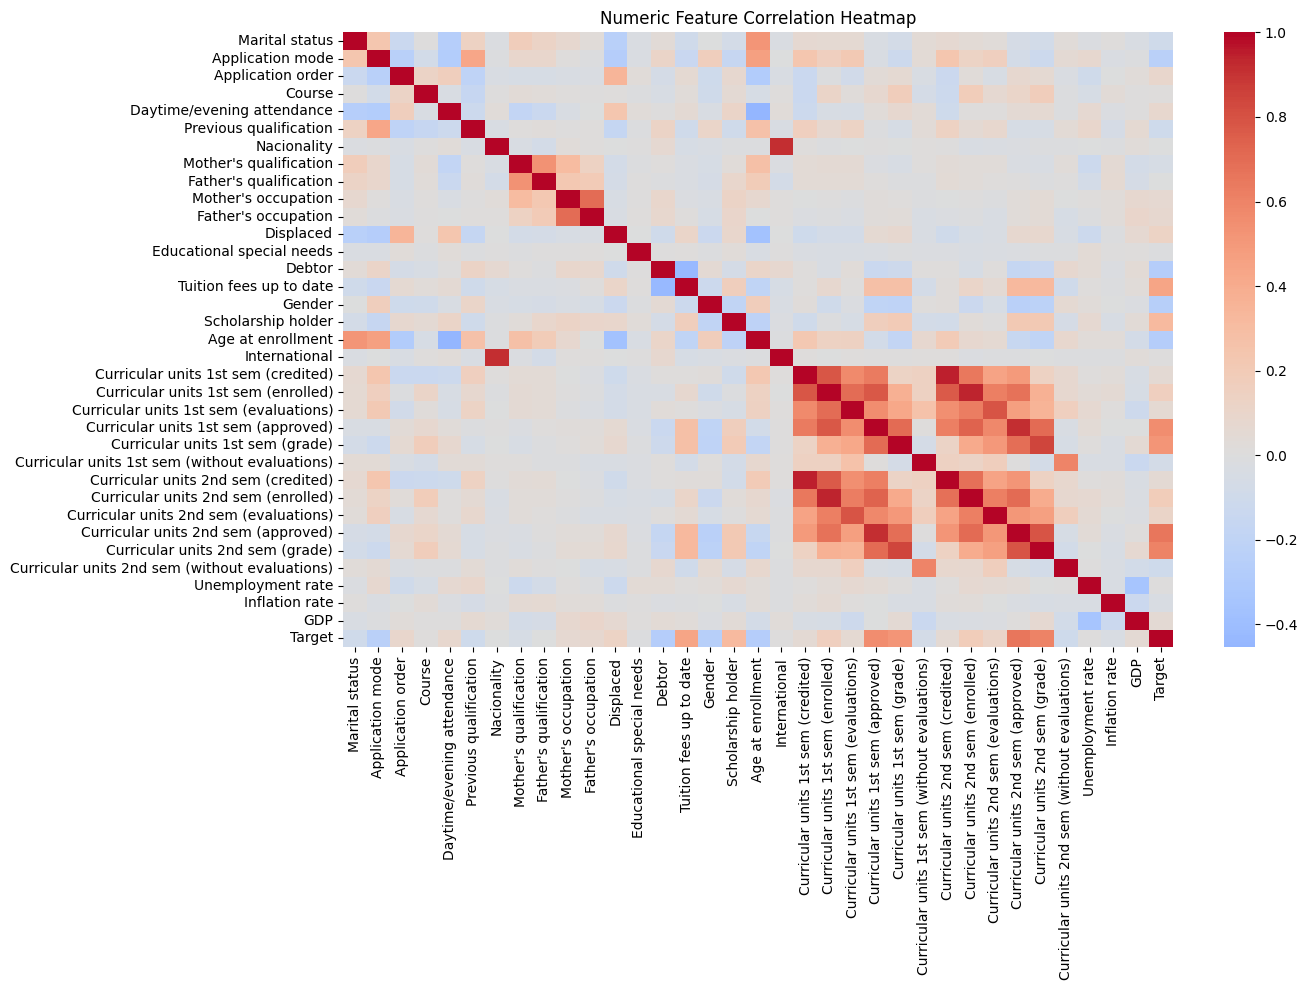

Target                                    1.000000
Curricular units 2nd sem (approved)       0.653995
Curricular units 2nd sem (grade)          0.605350
Curricular units 1st sem (approved)       0.554881
Curricular units 1st sem (grade)          0.519927
Tuition fees up to date                   0.442138
Scholarship holder                        0.313018
Age at enrollment                        -0.267229
Debtor                                   -0.267207
Gender                                   -0.251955
Application mode                         -0.233888
Curricular units 2nd sem (enrolled)       0.182897
Curricular units 1st sem (enrolled)       0.161074
Displaced                                 0.126113
Curricular units 2nd sem (evaluations)    0.119239
Name: Target, dtype: float64

In [2]:
df = raw_df.copy()

if 'Target' not in df.columns:
    raise KeyError('Target column missing from dataset')

target_map = {'Dropout': 0, 'Graduate': 1}
df = df[df['Target'] != 'Enrolled']
df = df.drop_duplicates().reset_index(drop=True)
df['Target'] = df['Target'].map(target_map)

numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
if 'Target' not in numeric_cols:
    numeric_cols.append('Target')

corr_matrix = df[numeric_cols].corr(method='pearson')

print('Numeric columns:', len(numeric_cols))
print('Correlation matrix shape:', corr_matrix.shape)

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Numeric Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

corr_matrix['Target'].sort_values(key=lambda s: s.abs(), ascending=False).head(15)

# 모델 학습 피처 대비 영향 미미/미사용 피처 식별
상관계수 임계값을 활용해 타깃과의 연관성이 약한 피처를 선정하고, 학습 파이프라인이 기대하는 피처 목록과 비교하여 미사용 피처를 도출합니다.

In [3]:
threshold = 0.2
corr_to_target = corr_matrix['Target'].drop(labels=['Target'], errors='ignore')

feature_summary: list[dict[str, object]] = []
flagged_features: list[str] = []

for column in sorted(set(raw_df.columns) - {'Target'}):
    corr_value = corr_to_target.get(column, np.nan)
    used_in_model = column in feature_names_in_
    reasons: list[str] = []
    if not used_in_model:
        reasons.append('unused_in_pipeline')
    if pd.isna(corr_value) or abs(corr_value) < threshold:
        reasons.append('low_abs_corr')
    if reasons:
        flagged_features.append(column)
    feature_summary.append(
        {
            'feature': column,
            'dtype': str(raw_df[column].dtype),
            'corr_with_target': corr_value,
            'abs_corr': np.nan if pd.isna(corr_value) else abs(corr_value),
            'used_in_model': used_in_model,
            'flags': ', '.join(reasons) if reasons else '',
        }
    )

summary_df = (
    pd.DataFrame(feature_summary)
    .sort_values(by=['flags', 'used_in_model', 'abs_corr'], ascending=[False, True, True])
    .reset_index(drop=True)
 )

print('Flag threshold (|corr| < {:.3f})'.format(threshold))
print('Flagged features count:', len(flagged_features))
summary_df.head(20)

Flag threshold (|corr| < 0.200)
Flagged features count: 24


,feature,dtype,corr_with_target,abs_corr,used_in_model,flags
0,Nacionality,int64,-0.003823,0.003823,False,"unused_in_pipeline, low_abs_corr"
1,Father's qualification,int64,-0.003850,0.003850,False,"unused_in_pipeline, low_abs_corr"
2,Unemployment rate,float64,0.004198,0.004198,False,"unused_in_pipeline, low_abs_corr"
3,International,int64,0.006181,0.006181,False,"unused_in_pipeline, low_abs_corr"
4,Course,int64,0.006814,0.006814,False,"unused_in_pipeline, low_abs_corr"
5,Educational special needs,int64,-0.007254,0.007254,False,"unused_in_pipeline, low_abs_corr"
6,Inflation rate,float64,-0.030326,0.030326,True,low_abs_corr
7,Curricular units 1st sem (credited),int64,0.046900,0.046900,True,low_abs_corr
8,Mother's qualification,int64,-0.048459,0.048459,True,low_abs_corr
9,GDP,float64,0.050260,0.050260,True,low_abs_corr


In [4]:
flagged_df = summary_df[summary_df['flags'] != '']
print('Flagged feature names:')
print(flagged_df['feature'].tolist())
flagged_df

Flagged feature names:
['Nacionality', "Father's qualification", 'Unemployment rate', 'International', 'Course', 'Educational special needs', 'Inflation rate', 'Curricular units 1st sem (credited)', "Mother's qualification", 'GDP', 'Curricular units 2nd sem (credited)', 'Curricular units 1st sem (evaluations)', "Mother's occupation", "Father's occupation", 'Curricular units 1st sem (without evaluations)', 'Daytime/evening attendance', 'Application order', 'Marital status', 'Curricular units 2nd sem (without evaluations)', 'Previous qualification', 'Curricular units 2nd sem (evaluations)', 'Displaced', 'Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)']


,feature,dtype,corr_with_target,abs_corr,used_in_model,flags
0,Nacionality,int64,-0.003823,0.003823,False,"unused_in_pipeline, low_abs_corr"
1,Father's qualification,int64,-0.003850,0.003850,False,"unused_in_pipeline, low_abs_corr"
2,Unemployment rate,float64,0.004198,0.004198,False,"unused_in_pipeline, low_abs_corr"
3,International,int64,0.006181,0.006181,False,"unused_in_pipeline, low_abs_corr"
4,Course,int64,0.006814,0.006814,False,"unused_in_pipeline, low_abs_corr"
5,Educational special needs,int64,-0.007254,0.007254,False,"unused_in_pipeline, low_abs_corr"
6,Inflation rate,float64,-0.030326,0.030326,True,low_abs_corr
7,Curricular units 1st sem (credited),int64,0.046900,0.046900,True,low_abs_corr
8,Mother's qualification,int64,-0.048459,0.048459,True,low_abs_corr
9,GDP,float64,0.050260,0.050260,True,low_abs_corr


# 스트림릿 입력 구성 업데이트 스크립트 생성
분석 결과를 활용해 Streamlit 앱(`../pages/streamlit.py`)에서 제거할 입력 요소 목록과 패치 스크립트를 자동으로 생성합니다.

In [5]:
streamlit_path = Path('..') / 'pages' / 'streamlit.py'
streamlit_source = streamlit_path.read_text(encoding='utf-8')

features_to_hide = sorted({feat for feat in flagged_features if feat in feature_names_in_})
features_to_drop_entirely = sorted({feat for feat in flagged_features if feat not in feature_names_in_})

print('Features flagged for hiding in Streamlit (still used by model):')
print(features_to_hide)
print('\nDataset-only features (already unused in model):')
print(features_to_drop_entirely)

patch_lines = [
    "# --- auto-generated guidance ---",
    'FEATURES_TO_HIDE = ' + json.dumps(features_to_hide, ensure_ascii=False, indent=2),
    '',
    '# Apply these defaults in Streamlit to avoid rendering inputs for the listed features.',
]

patch_text = '\n'.join(patch_lines)
print('\nSuggested patch helper snippet:')
print(patch_text)

with open('streamlit_guidance.txt', 'w', encoding='utf-8') as fh:
    fh.write(patch_text)

print('\nGuidance saved to streamlit_guidance.txt')

Features flagged for hiding in Streamlit (still used by model):
['Application order', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (without evaluations)', 'Daytime/evening attendance', 'Displaced', "Father's occupation", 'GDP', 'Inflation rate', 'Marital status', "Mother's occupation", "Mother's qualification", 'Previous qualification']

Dataset-only features (already unused in model):
['Course', 'Educational special needs', "Father's qualification", 'International', 'Nacionality', 'Unemployment rate']

Suggested patch helper snippet:
# --- auto-generated guidance ---
FEATURES_TO_HIDE = [
  "Application order",
  "Curricular units 1st sem (credited)",
  "Curricular units 1st sem (enrolled)",
  "Curricular units 1st sem 